In [1]:
import exercise2_config as config
import pandas as pd
import numpy as np


train_images = pd.read_csv(config.TRAIN_DATA_FILE, header=None)
test_images = pd.read_csv(config.TEST_DATA_FILE, header=None)

train_data = np.array(train_images.iloc[:,1:])
train_labels = np.array(train_images.iloc[:,0])
test_data = np.array(test_images.iloc[:,1:])
test_labels = np.array(test_images.iloc[:,0]) 

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.exceptions import ConvergenceWarning
from datetime import datetime
ConvergenceWarning('ignore')


def algorithm_pipeline(X_train_data, y_train_data, 
                       model, param_grid, cv=5, scoring_fit='accuracy'):
    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid, 
        cv=cv, 
        n_jobs=-1, 
        scoring=scoring_fit,
        verbose=2,
        return_train_score=True # set this for train score
    )
    return gs.fit(X_train_data, y_train_data)


random_state = round(datetime.timestamp(datetime.now()))
print(f'random_state = {random_state}')
mlp = MLPClassifier(random_state=random_state, verbose=2)
parameter_space = {
    'max_iter' : np.linspace(10, 100, num=5, dtype=int),
    'hidden_layer_sizes' : np.linspace(10, 100, num=10, dtype=int),
    'activation' : ['logistic'],
    'solver' : ['sgd'],
    'learning_rate_init' : np.linspace(0.001, 0.1, num=10), #  Only used when solver=’sgd’ or ‘adam’.
    'learning_rate' : ['constant'] # Only used when solver='sgd'
}
clf = algorithm_pipeline(train_data, train_labels, mlp, parameter_space, 4)

In [3]:
print(f'random_state = {random_state}')
print(clf.best_estimator_)
print(clf.best_params_)
print(clf.best_score_)
print(clf.score(test_data, test_labels))

random_state = 1649282261
MLPClassifier(activation='logistic', hidden_layer_sizes=90, max_iter=100,
              random_state=1649282261, solver='sgd', verbose=2)
{'activation': 'logistic', 'hidden_layer_sizes': 90, 'learning_rate': 'constant', 'learning_rate_init': 0.001, 'max_iter': 100, 'solver': 'sgd'}
0.9476333333333333
0.9585


In [4]:
class Result:
  def __init__(self, hidden_layer_size, learning_rate, max_iter, accuracy):
    self.hidden_layer_size = hidden_layer_size
    self.learning_rate = learning_rate
    self.max_iter = max_iter
    self.accuracy = accuracy

results = []
for index in range(len(clf.cv_results_['param_hidden_layer_sizes'])):
  result = Result(clf.cv_results_['param_hidden_layer_sizes'][index],
                  clf.cv_results_['param_learning_rate_init'][index],
                  clf.cv_results_['param_max_iter'][index],
                  clf.cv_results_['mean_test_score'][index])
  results.append(result)


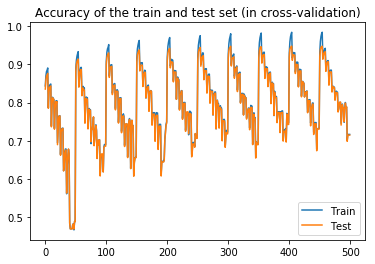

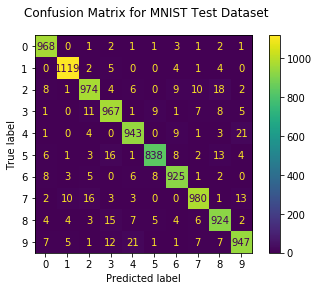

In [5]:
from sklearn.metrics import plot_confusion_matrix
import matplotlib.pyplot as plt

plt.plot(clf.cv_results_['mean_train_score'], label='Train')
plt.plot(clf.cv_results_['mean_test_score'], label='Test')
plt.legend()
plt.title("Accuracy of the train and test set (in cross-validation)")
plt.show()

fig=plot_confusion_matrix(clf, test_data, test_labels, display_labels=["0","1","2","3","4","5","6","7","8","9"])
fig.figure_.suptitle("Confusion Matrix for MNIST Test Dataset")
plt.show()

# Report

In [19]:
#This generates pdf with results
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
def pd_dataframe_to_pdf(df, pdfName):
    fig, ax =plt.subplots(figsize=(12,4))
    ax.axis('tight')
    ax.axis('off')
    the_table = ax.table(cellText=df.values,colLabels=df.columns,loc='center')

    pp = PdfPages(pdfName)
    pp.savefig(fig, bbox_inches='tight')
    pp.close()
    

In [20]:
#Transfer results to panda dataframe and call function above
df = pd.DataFrame(columns=['Hidden Layer Size', 'Learning Rate', 'Max Iterations / Epochs', 'Accuracy'])

for index in range(len(clf.cv_results_['param_hidden_layer_sizes'])):
    dicts = {'Hidden Layer Size' : clf.cv_results_['param_hidden_layer_sizes'][index] , 'Learning Rate' : clf.cv_results_['param_learning_rate_init'][index], 'Max Iterations / Epochs' :clf.cv_results_['param_max_iter'][index], 'Accuracy' : clf.cv_results_['mean_test_score'][index]}
    df=df.append(dicts,ignore_index=True)

pd_dataframe_to_pdf(df, "table_with_results_Ex2b.pdf")

In [ ]:
# Created panda dataframe from results above and generated pdf from it -> simpler way
# I would personally remove previously implemented latex solution below,but not sure if it ok for others

In [ ]:
from pylatex import Document, Command, LongTable
from pylatex.utils import NoEscape

doc = Document(page_numbers=False)

# Add title
doc.preamble.append(Command('title', 'Exercise 2b - MLP'))
doc.preamble.append(Command('date', ''))
doc.append(NoEscape(r'\maketitle'))


# Add table with results
with doc.create(LongTable('l l l l l')) as data_table:
  data_table.add_hline()
  data_table.add_row(['Hidden Layer Size', 'Learning Rate', 'Max Iterations', 'Accuracy', 'Best?'])
  data_table.add_hline()
  data_table.end_table_header()
  data_table.add_hline()

  for result in results:
    row = [result.hidden_layer_size,
           round(result.learning_rate, 5),
           result.max_iter,
           round(result.accuracy, 5), 
           'YES' if round(clf.best_score_, 5) == round(result.accuracy, 5) else ''] 

    data_table.add_row(row)
    data_table.add_hline()

  data_table.end_table_last_footer()
  

try:
  doc.generate_pdf('E2b')
  doc.generate_tex('E2b')
except:
  # The generate_pdf sometimes fails and prints some message, but the pdf is actually generated. 
  # Not worth debugging :)
  pass
